**Author:** Raoul Malm  

**Abstract:** 

We implement a deep neural network consisting of convolutional and fully connected layers to classify  handwritten digits of the MNIST dataset. The labeled dataset consists of 42000 images of size 28x28 = 784 pixels (one gray-scale number) including the corresponding labels from 0,..,9. The test set consists of 28000 images. Each image is normalized such that each pixel takes on values in the range [0,1]. First, we try out basic models like logistic regression, random forest and so on. After that the images are fed into the neural network, which has the following architecture:

- input layer: [.,784]
- layer: Conv1 -> ReLu -> MaxPool: [.,14,14,36] 
- layer: Conv2 -> ReLu -> MaxPool: [.,7,7,36]
- layer: Conv3 -> ReLu -> MaxPool: [.,4,4,36]
- layer: FC -> ReLu: [.,576]
- output layer: FC -> ReLu: [.,10]

This architecture is implemented with TensorFlow. In order to prevent the network from overfitting during learning we implement dropout and data augmentation, i.e. new images are generated from the original ones via rotation, translation and zooming. Finally, we predict the digit classes for the test set and write the submission file.     

**Results:** 

- The best results are achieved by using 10-fold cross validation, by stacking the neural networks on top of each other and then by training a meta model. Since each neural network is trained for 15 epochs including data augmentation which takes roughly 30 minutes on kaggle hardware, it takes in total roughly 5 hours. The final accuracy is 99.51% on the public test set. Note that we have attached saver and summary tensors to the graph, which slows down the computation.  
<br>

- We can also train one neural network and implement a training/validation split of 95%/5% on the labeled original images. Training on 39900 original images and including data augmentation we can achieve after 15 epochs an accuracy of roughly 99.43% on the validation set of 2100 images. Of course this can vary depending on the specific training/validation splits. It also takes roughly 30 minutes on kaggle hardware. On the public test set it can achieve an accuracy of about 99.30%. Training on all data one can actually achieve the 99.43%.

**Update:** 

- Stacking of models and training of a meta-model is now implemented.

- The neural network is now implemented as a python class and the complete TensorFlow session can be saved to or restored from a file. We also implement tensor summaries, which can be visualized with TensorBoard.

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Try out some basic models with sklearn](#4-bullet)
5. [Build the neural network with TensorFlow](#5-bullet)
6. [Train and validate the neural network](#6-bullet)
7. [Stacking of models and training a meta-model](#7-bullet)
8. [Submit the test results](#8-bullet)


**Reference:** 

[TensorFlow deep NN by Kirill Kliavin](https://www.kaggle.com/kakauandme/tensorflow-deep-nn?scriptVersionId=164725)


# 1. Libraries and settings <a class="anchor" id="1-bullet"></a>
- import relevant libraries
- set number of features, neurons and filter size of the neural network 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

Using TensorFlow backend.


/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification: ['.DS_Store', 'input', 'working']
/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification/working: ['.DS_Store', '.ipynb_checkpoints', 'checkpoint', 'logs', 'MNIST_Image_Class._TensorFlow_CNN_99.51_percent_Test_Acc..ipynb', 'nn0.data-00000-of-00001', 'nn0.index', 'nn0.meta', 'nn1.data-00000-of-00001', 'nn1.index', 'nn1.meta', 'nn2.data-00000-of-00001', 'nn2.index', 'nn2.meta', 'nn3.data-00000-of-00001', 'nn3.index', 'nn3.meta', 'nn4.data-00000-of-00001', 'nn4.index', 'nn4.meta', 'nn5.data-00000-of-00001', 'nn5.index', 'nn5.meta', 'nn6.data-00000-of-00001', 'nn6.index', 'nn6.meta', 'nn7.data-00000-of-00001', 'nn7.index', 'nn7.meta', 'nn8.data-00000-of-00001', 'nn8.index', 'nn8.meta', 'nn9.data-00000-of-00001', 'nn9.index', 'nn9.meta', 'submission.csv']


# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load images and have a first look
- normalize images

In [2]:
## load and check data

if os.path.isfile('../input/train.csv'):
    data_df = pd.read_csv('../input/train.csv') # on kaggle 
    print('train.csv loaded: data_df({0[0]},{0[1]})'.format(data_df.shape))
elif os.path.isfile('data/train.csv'):
    data_df = pd.read_csv('data/train.csv') # on local environment
    print('train.csv loaded: data_df({0[0]},{0[1]})'.format(data_df.shape))
else:
    print('Error: train.csv not found')

# basic info about data
#print('')
#print(data_df.info())

# no missing values
print('')
print(data_df.isnull().any().describe())

# 10 different labels ranging from 0 to 9
print('')
print('distinct labels ', data_df['label'].unique())

# data are approximately balanced (less often occurs 5, most often 1)
print('')
print(data_df['label'].value_counts())

train.csv loaded: data_df(42000,785)

count       785
unique        1
top       False
freq        785
dtype: object

distinct labels  [1 0 4 7 3 5 8 9 2 6]

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


x_train_valid.shape =  (42000, 28, 28, 1)
y_train_valid_labels.shape =  (42000,)
image_size =  784
image_width =  28
image_height =  28
labels_count =  10


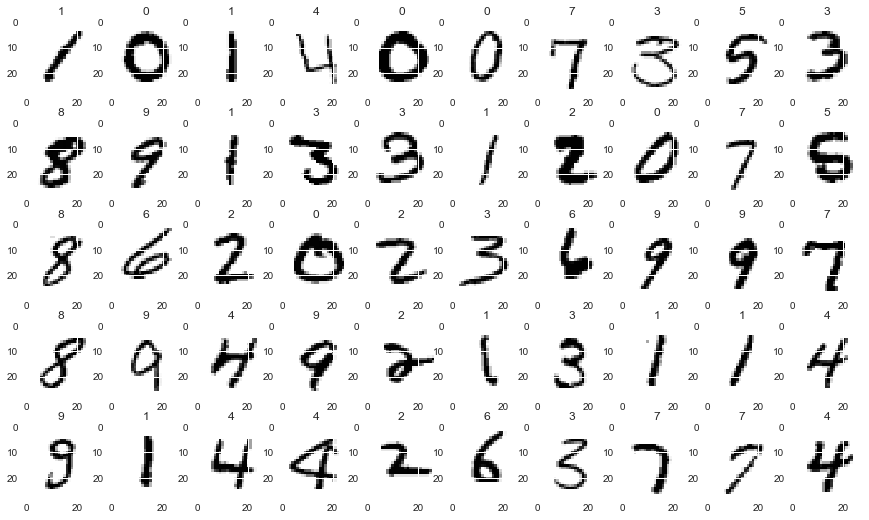

In [3]:
## normalize data and split into training and validation sets

# function to normalize data
def normalize_data(data): 
    # scale features using statistics that are robust to outliers
    #rs = sklearn.preprocessing.RobustScaler()
    #rs.fit(data)
    #data = rs.transform(data)
    #data = (data-data.mean())/(data.std()) # standardisation
    data = data / data.max() # convert from [0:255] to [0.:1.]
    #data = ((data / 255.)-0.5)*2. # convert from [0:255] to [-1.:+1.]
    return data

# convert class labels from scalars to one-hot vectors e.g. 1 => [0 1 0 0 0 0 0 0 0 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# convert one-hot encodings into labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

# computet the accuracy of label predictions
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

# computet the accuracy of one-hot encoded predictions
def accuracy_from_one_hot_labels(y_target, y_pred):
    y_target = one_hot_to_dense(y_target).reshape(-1,)
    y_pred = one_hot_to_dense(y_pred).reshape(-1,)
    return np.mean(y_target == y_pred)

# extract and normalize images
x_train_valid = data_df.iloc[:,1:].values.reshape(-1,28,28,1) # (42000,28,28,1) array
x_train_valid = x_train_valid.astype(np.float) # convert from int64 to float32
x_train_valid = normalize_data(x_train_valid)
image_width = image_height = 28
image_size = 784

# extract image labels
y_train_valid_labels = data_df.iloc[:,0].values # (42000,1) array
labels_count = np.unique(y_train_valid_labels).shape[0]; # number of different labels = 10

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(y_train_valid_labels[i])
    plt.imshow(x_train_valid[i].reshape(28,28), cmap=cm.binary)
    
# labels in one hot representation
y_train_valid = dense_to_one_hot(y_train_valid_labels, labels_count).astype(np.uint8)

# dictionaries for saving results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}

print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid_labels.shape = ', y_train_valid_labels.shape)
print('image_size = ', image_size )
print('image_width = ', image_width)
print('image_height = ', image_height)
print('labels_count = ', labels_count)


# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- generate new images via rotations, translations and zooming

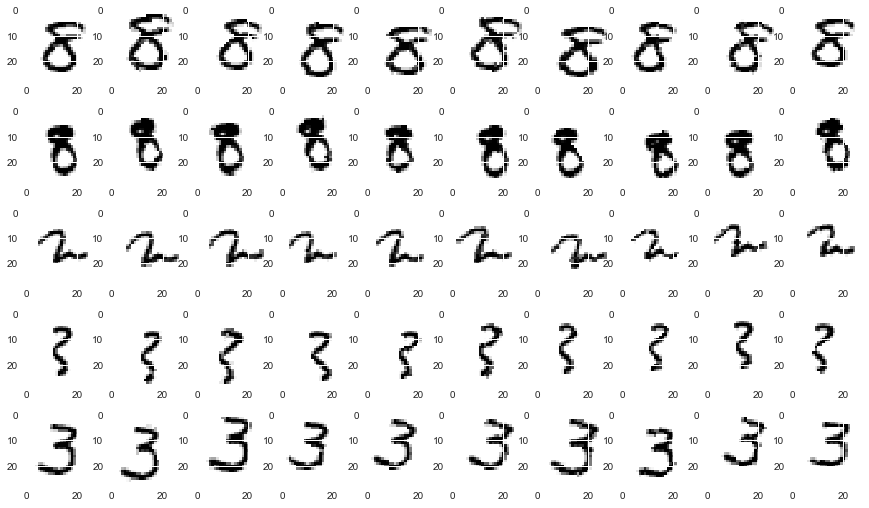

In [4]:
## augment data

# generate new images via rotations, translations, zoom using keras
def generate_images(imgs):
    
    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
  
    return imgs[0]

# check image generation
fig,axs = plt.subplots(5,10, figsize=(15,9))
for i in range(5):
    n = np.random.randint(0,x_train_valid.shape[0]-2)
    axs[i,0].imshow(x_train_valid[n:n+1].reshape(28,28),cmap=cm.binary)
    axs[i,1].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,2].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,3].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,4].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,5].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,6].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,7].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,8].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,9].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)

# 4. Try out some basic models with sklearn <a class="anchor" id="4-bullet"></a> 

In [5]:
## First try out some basic sklearn models

logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs',
                                                 multi_class='multinomial')
decision_tree = sklearn.tree.DecisionTreeClassifier()
extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0)
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose=0)
random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0)
gaussianNB = sklearn.naive_bayes.GaussianNB()

# store models in dictionary
base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               'gradient_boost': gradient_boost, 'random_forest': random_forest, 
               'decision_tree': decision_tree, 'gaussianNB': gaussianNB}

# choose models for out-of-folds predictions
take_models = ['logreg','random_forest','extra_trees']

for mn in take_models:
    train_acc[mn] = []
    valid_acc[mn] = []

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

    # start timer
    start = datetime.datetime.now();

    # train and validation data of original images
    x_train = x_train_valid[train_index].reshape(-1,784)
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index].reshape(-1,784)
    y_valid = y_train_valid[valid_index]

    for mn in take_models:

        # create cloned model from base models
        model = sklearn.base.clone(base_models[mn])
        model.fit(x_train, one_hot_to_dense(y_train))

        # predictions
        y_train_pred[mn] = model.predict_proba(x_train)
        y_valid_pred[mn] = model.predict_proba(x_valid)
        train_acc[mn].append(accuracy_from_one_hot_labels(y_train_pred[mn], y_train))
        valid_acc[mn].append(accuracy_from_one_hot_labels(y_valid_pred[mn], y_valid))

        print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[mn][-1], 
                                                             valid_acc[mn][-1]))
    # only one iteration
    if False:
        break;

print(mn+': averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                        np.mean(valid_acc[mn])))


0 : logreg train/valid accuracy = 0.940/0.920
0 : random_forest train/valid accuracy = 0.999/0.941
0 : extra_trees train/valid accuracy = 1.000/0.946
1 : logreg train/valid accuracy = 0.940/0.922
1 : random_forest train/valid accuracy = 0.999/0.938
1 : extra_trees train/valid accuracy = 1.000/0.946
2 : logreg train/valid accuracy = 0.939/0.928
2 : random_forest train/valid accuracy = 0.999/0.938
2 : extra_trees train/valid accuracy = 1.000/0.950
3 : logreg train/valid accuracy = 0.939/0.924
3 : random_forest train/valid accuracy = 0.999/0.936
3 : extra_trees train/valid accuracy = 1.000/0.945
4 : logreg train/valid accuracy = 0.940/0.920
4 : random_forest train/valid accuracy = 0.999/0.942
4 : extra_trees train/valid accuracy = 1.000/0.946
5 : logreg train/valid accuracy = 0.939/0.919
5 : random_forest train/valid accuracy = 0.999/0.943
5 : extra_trees train/valid accuracy = 1.000/0.947
6 : logreg train/valid accuracy = 0.941/0.916
6 : random_forest train/valid accuracy = 0.999/0.941
6

logreg averaged train/valid accuracy = 0.940/0.920
random_forest averaged train/valid accuracy = 0.999/0.939
extra_trees averaged train/valid accuracy = 1.000/0.945


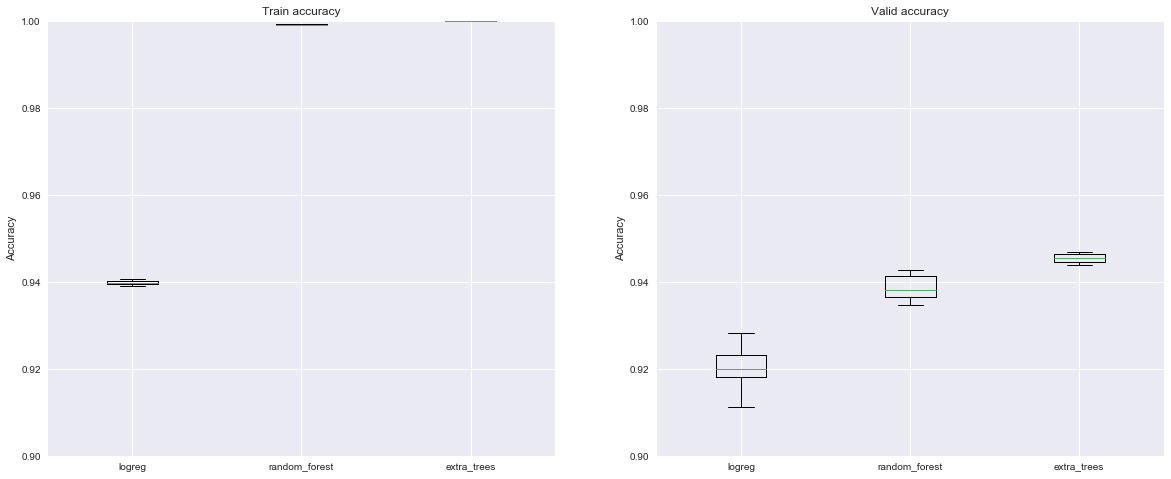

In [6]:
## compare accuracies of base models

# boxplot algorithm comparison
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
plt.title('Train accuracy')
plt.boxplot([train_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');
ax.set_ylim([0.90,1.0])

ax = fig.add_subplot(1,2,2)
plt.title('Valid accuracy')
plt.boxplot([valid_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');
ax.set_ylim([0.90,1.0])

for mn in train_acc.keys():
    print(mn + ' averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                             np.mean(valid_acc[mn])))

# 5. Build the neural network with tensorflow <a class="anchor" id="5-bullet"></a> 

In [7]:
## build the neural network class

class nn_class:
# class that implements the neural network

    # constructor
    def __init__(self, nn_name = 'nn_1'):

        # tunable hyperparameters for nn architecture
        self.s_f_conv1 = 3; # filter size of first convolution layer (default = 3)
        self.n_f_conv1 = 36; # number of features of first convolution layer (default = 36)
        self.s_f_conv2 = 3; # filter size of second convolution layer (default = 3)
        self.n_f_conv2 = 36; # number of features of second convolution layer (default = 36)
        self.s_f_conv3 = 3; # filter size of third convolution layer (default = 3)
        self.n_f_conv3 = 36; # number of features of third convolution layer (default = 36)
        self.n_n_fc1 = 576; # number of neurons of first fully connected layer (default = 576)

        # tunable hyperparameters for training
        self.mb_size = 50 # mini batch size
        self.keep_prob = 0.33 # keeping probability with dropout regularization 
        self.learn_rate_array = [10*1e-4, 7.5*1e-4, 5*1e-4, 2.5*1e-4, 1*1e-4, 1*1e-4,
                                 1*1e-4,0.75*1e-4, 0.5*1e-4, 0.25*1e-4, 0.1*1e-4, 
                                 0.1*1e-4, 0.075*1e-4,0.050*1e-4, 0.025*1e-4, 0.01*1e-4, 
                                 0.0075*1e-4, 0.0050*1e-4,0.0025*1e-4,0.001*1e-4]
        self.learn_rate_step_size = 3 # in terms of epochs
        
        # parameters
        self.learn_rate = self.learn_rate_array[0]
        self.learn_rate_pos = 0 # current position pointing to current learning rate
        self.index_in_epoch = 0 
        self.current_epoch = 0
        self.log_step = 0.2 # log results in terms of epochs
        self.n_log_step = 0 # counting current number of mini batches trained on
        self.use_tb_summary = False # True = use tensorboard visualization
        self.use_tf_saver = False # True = use saver to save the model
        self.nn_name = nn_name # name of the neural network
        
        # permutation array
        self.perm_array = np.array([])
        
    # function to get the next mini batch
    def next_mini_batch(self):

        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size
        self.current_epoch += self.mb_size/len(self.x_train)  
        
        # adapt length of permutation array
        if not len(self.perm_array) == len(self.x_train):
            self.perm_array = np.arange(len(self.x_train))
        
        # shuffle once at the start of epoch
        if start == 0:
            np.random.shuffle(self.perm_array)

        # at the end of the epoch
        if self.index_in_epoch > self.x_train.shape[0]:
            np.random.shuffle(self.perm_array) # shuffle data
            start = 0 # start next epoch
            self.index_in_epoch = self.mb_size # set index to mini batch size
            
            if self.train_on_augmented_data:
                # use augmented data for the next epoch
                self.x_train_aug = normalize_data(self.generate_images(self.x_train))
                self.y_train_aug = self.y_train
                
        
        end = self.index_in_epoch
        
        if self.train_on_augmented_data:
            # use augmented data
            x_tr = self.x_train_aug[self.perm_array[start:end]]
            y_tr = self.y_train_aug[self.perm_array[start:end]]
        else:
            # use original data
            x_tr = self.x_train[self.perm_array[start:end]]
            y_tr = self.y_train[self.perm_array[start:end]]
        
        return x_tr, y_tr
               
    # generate new images via rotations, translations, zoom using keras
    def generate_images(self, imgs):
    
        print('generate new set of images')
        
        # rotations, translations, zoom
        image_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
            zoom_range = 0.1)

        # get transformed images
        imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                    batch_size=len(imgs), shuffle = False).next()    

        return imgs[0]

    # weight initialization
    def weight_variable(self, shape, name = None):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name = name)

    # bias initialization
    def bias_variable(self, shape, name = None):
        initial = tf.constant(0.1, shape=shape) #  positive bias
        return tf.Variable(initial, name = name)

    # 2D convolution
    def conv2d(self, x, W, name = None):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name = name)

    # max pooling
    def max_pool_2x2(self, x, name = None):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME', name = name)

    # attach summaries to a tensor for TensorBoard visualization
    def summary_variable(self, var, var_name):
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)
    
    # function to create the graph
    def create_graph(self):

        # reset default graph
        tf.reset_default_graph()

        # variables for input and output 
        self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=[None,28,28,1], 
                                        name='x_data_tf')
        self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=[None,10], name='y_data_tf')

        # 1.layer: convolution + max pooling
        self.W_conv1_tf = self.weight_variable([self.s_f_conv1, self.s_f_conv1, 1,
                                                self.n_f_conv1], 
                                               name = 'W_conv1_tf') # (5,5,1,32)
        self.b_conv1_tf = self.bias_variable([self.n_f_conv1], name = 'b_conv1_tf') # (32)
        self.h_conv1_tf = tf.nn.relu(self.conv2d(self.x_data_tf, 
                                                 self.W_conv1_tf) + self.b_conv1_tf, 
                                     name = 'h_conv1_tf') # (.,28,28,32)
        self.h_pool1_tf = self.max_pool_2x2(self.h_conv1_tf, 
                                            name = 'h_pool1_tf') # (.,14,14,32)

        # 2.layer: convolution + max pooling
        self.W_conv2_tf = self.weight_variable([self.s_f_conv2, self.s_f_conv2, 
                                                self.n_f_conv1, self.n_f_conv2], 
                                               name = 'W_conv2_tf')
        self.b_conv2_tf = self.bias_variable([self.n_f_conv2], name = 'b_conv2_tf')
        self.h_conv2_tf = tf.nn.relu(self.conv2d(self.h_pool1_tf, 
                                                 self.W_conv2_tf) + self.b_conv2_tf, 
                                     name ='h_conv2_tf') #(.,14,14,32)
        self.h_pool2_tf = self.max_pool_2x2(self.h_conv2_tf, name = 'h_pool2_tf') #(.,7,7,32)

        # 3.layer: convolution + max pooling
        self.W_conv3_tf = self.weight_variable([self.s_f_conv3, self.s_f_conv3, 
                                                self.n_f_conv2, self.n_f_conv3], 
                                               name = 'W_conv3_tf')
        self.b_conv3_tf = self.bias_variable([self.n_f_conv3], name = 'b_conv3_tf')
        self.h_conv3_tf = tf.nn.relu(self.conv2d(self.h_pool2_tf, 
                                                 self.W_conv3_tf) + self.b_conv3_tf, 
                                     name = 'h_conv3_tf') #(.,7,7,32)
        self.h_pool3_tf = self.max_pool_2x2(self.h_conv3_tf, 
                                            name = 'h_pool3_tf') # (.,4,4,32)

        # 4.layer: fully connected
        self.W_fc1_tf = self.weight_variable([4*4*self.n_f_conv3,self.n_n_fc1], 
                                             name = 'W_fc1_tf') # (4*4*32, 1024)
        self.b_fc1_tf = self.bias_variable([self.n_n_fc1], name = 'b_fc1_tf') # (1024)
        self.h_pool3_flat_tf = tf.reshape(self.h_pool3_tf, [-1,4*4*self.n_f_conv3], 
                                          name = 'h_pool3_flat_tf') # (.,1024)
        self.h_fc1_tf = tf.nn.relu(tf.matmul(self.h_pool3_flat_tf, 
                                             self.W_fc1_tf) + self.b_fc1_tf, 
                                   name = 'h_fc1_tf') # (.,1024)
      
        # add dropout
        self.keep_prob_tf = tf.placeholder(dtype=tf.float32, name = 'keep_prob_tf')
        self.h_fc1_drop_tf = tf.nn.dropout(self.h_fc1_tf, self.keep_prob_tf, 
                                           name = 'h_fc1_drop_tf')

        # 5.layer: fully connected
        self.W_fc2_tf = self.weight_variable([self.n_n_fc1, 10], name = 'W_fc2_tf')
        self.b_fc2_tf = self.bias_variable([10], name = 'b_fc2_tf')
        self.z_pred_tf = tf.add(tf.matmul(self.h_fc1_drop_tf, self.W_fc2_tf), 
                                self.b_fc2_tf, name = 'z_pred_tf')# => (.,10)

        # cost function
        self.cross_entropy_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=self.y_data_tf, logits=self.z_pred_tf), name = 'cross_entropy_tf')
     
        # optimisation function
        self.learn_rate_tf = tf.placeholder(dtype=tf.float32, name="learn_rate_tf")
        self.train_step_tf = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
            self.cross_entropy_tf, name = 'train_step_tf')

        # predicted probabilities in one-hot encoding
        self.y_pred_proba_tf = tf.nn.softmax(self.z_pred_tf, name='y_pred_proba_tf') 
        
        # tensor of correct predictions
        self.y_pred_correct_tf = tf.equal(tf.argmax(self.y_pred_proba_tf, 1),
                                          tf.argmax(self.y_data_tf, 1),
                                          name = 'y_pred_correct_tf')  
        
        # accuracy 
        self.accuracy_tf = tf.reduce_mean(tf.cast(self.y_pred_correct_tf, dtype=tf.float32),
                                         name = 'accuracy_tf')

        # tensors to save intermediate accuracies and losses during training
        self.train_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='train_loss_tf', validate_shape = False)
        self.valid_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='valid_loss_tf', validate_shape = False)
        self.train_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='train_acc_tf', validate_shape = False)
        self.valid_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='valid_acc_tf', validate_shape = False)
     
        # number of weights and biases
        num_weights = (self.s_f_conv1**2*self.n_f_conv1 
                       + self.s_f_conv2**2*self.n_f_conv1*self.n_f_conv2 
                       + self.s_f_conv3**2*self.n_f_conv2*self.n_f_conv3 
                       + 4*4*self.n_f_conv3*self.n_n_fc1 + self.n_n_fc1*10)
        num_biases = self.n_f_conv1 + self.n_f_conv2 + self.n_f_conv3 + self.n_n_fc1
        print('num_weights =', num_weights)
        print('num_biases =', num_biases)
        
        return None  
    
    def attach_summary(self, sess):
        
        # create summary tensors for tensorboard
        self.use_tb_summary = True
        self.summary_variable(self.W_conv1_tf, 'W_conv1_tf')
        self.summary_variable(self.b_conv1_tf, 'b_conv1_tf')
        self.summary_variable(self.W_conv2_tf, 'W_conv2_tf')
        self.summary_variable(self.b_conv2_tf, 'b_conv2_tf')
        self.summary_variable(self.W_conv3_tf, 'W_conv3_tf')
        self.summary_variable(self.b_conv3_tf, 'b_conv3_tf')
        self.summary_variable(self.W_fc1_tf, 'W_fc1_tf')
        self.summary_variable(self.b_fc1_tf, 'b_fc1_tf')
        self.summary_variable(self.W_fc2_tf, 'W_fc2_tf')
        self.summary_variable(self.b_fc2_tf, 'b_fc2_tf')
        tf.summary.scalar('cross_entropy_tf', self.cross_entropy_tf)
        tf.summary.scalar('accuracy_tf', self.accuracy_tf)

        # merge all summaries for tensorboard
        self.merged = tf.summary.merge_all()

        # initialize summary writer 
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), 'logs', (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)

    def attach_saver(self):
        # initialize tensorflow saver
        self.use_tf_saver = True
        self.saver_tf = tf.train.Saver()

    # function to train the graph
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch = 1, 
                    train_on_augmented_data = False):

        # train on original or augmented data
        self.train_on_augmented_data = train_on_augmented_data
        
        # training and validation data
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        # use augmented data
        if self.train_on_augmented_data:
            print('generate new set of images')
            self.x_train_aug = normalize_data(self.generate_images(self.x_train))
            self.y_train_aug = self.y_train
        
        # parameters
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_acc, valid_loss, valid_acc = [],[],[],[]
        
        # start timer
        start = datetime.datetime.now();
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
        print('learnrate = ',self.learn_rate,', n_epoch = ', n_epoch,
              ', mb_size = ', self.mb_size)
        # looping over mini batches
        for i in range(int(n_epoch*mb_per_epoch)+1):

            # adapt learn_rate
            self.learn_rate_pos = int(self.current_epoch // self.learn_rate_step_size)
            if not self.learn_rate == self.learn_rate_array[self.learn_rate_pos]:
                self.learn_rate = self.learn_rate_array[self.learn_rate_pos]
                print(datetime.datetime.now()-start,': set learn rate to %.6f'%self.learn_rate)
            
            # get new batch
            x_batch, y_batch = self.next_mini_batch() 

            # run the graph
            sess.run(self.train_step_tf, feed_dict={self.x_data_tf: x_batch, 
                                                    self.y_data_tf: y_batch, 
                                                    self.keep_prob_tf: self.keep_prob, 
                                                    self.learn_rate_tf: self.learn_rate})
             
            
            # store losses and accuracies
            if i%int(self.log_step*mb_per_epoch) == 0 or i == int(n_epoch*mb_per_epoch):
             
                self.n_log_step += 1 # for logging the results
                
                feed_dict_train = {
                    self.x_data_tf: self.x_train[self.perm_array[:len(self.x_valid)]], 
                    self.y_data_tf: self.y_train[self.perm_array[:len(self.y_valid)]], 
                    self.keep_prob_tf: 1.0}
                
                feed_dict_valid = {self.x_data_tf: self.x_valid, 
                                   self.y_data_tf: self.y_valid, 
                                   self.keep_prob_tf: 1.0}
                
                # summary for tensorboard
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)
                
                train_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_train))

                train_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_train))
                
                valid_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_valid))

                valid_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_valid))

                print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                    self.current_epoch, train_loss[-1], valid_loss[-1],
                    train_acc[-1], valid_acc[-1]))
     
        # concatenate losses and accuracies and assign to tensor variables
        tl_c = np.concatenate([self.train_loss_tf.eval(session=sess), train_loss], axis = 0)
        vl_c = np.concatenate([self.valid_loss_tf.eval(session=sess), valid_loss], axis = 0)
        ta_c = np.concatenate([self.train_acc_tf.eval(session=sess), train_acc], axis = 0)
        va_c = np.concatenate([self.valid_acc_tf.eval(session=sess), valid_acc], axis = 0)
   
        sess.run(tf.assign(self.train_loss_tf, tl_c, validate_shape = False))
        sess.run(tf.assign(self.valid_loss_tf, vl_c , validate_shape = False))
        sess.run(tf.assign(self.train_acc_tf, ta_c , validate_shape = False))
        sess.run(tf.assign(self.valid_acc_tf, va_c , validate_shape = False))
        
        print('running time for training: ', datetime.datetime.now() - start)
        return None
  
    # save tensors/summaries
    def save_model(self, sess):
        
        # tf saver
        if self.use_tf_saver:
            #filepath = os.path.join(os.getcwd(), 'logs' , self.nn_name)
            filepath = os.path.join(os.getcwd(), self.nn_name)
            self.saver_tf.save(sess, filepath)
        
        # tb summary
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()
        
        return None
  
    # forward prediction of current graph
    def forward(self, sess, x_data):
        y_pred_proba = self.y_pred_proba_tf.eval(session = sess, 
                                                 feed_dict = {self.x_data_tf: x_data,
                                                              self.keep_prob_tf: 1.0})
        return y_pred_proba
    
    # function to load tensors from a saved graph
    def load_tensors(self, graph):
        
        # input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")
        
        # weights and bias tensors
        self.W_conv1_tf = graph.get_tensor_by_name("W_conv1_tf:0")
        self.W_conv2_tf = graph.get_tensor_by_name("W_conv2_tf:0")
        self.W_conv3_tf = graph.get_tensor_by_name("W_conv3_tf:0")
        self.W_fc1_tf = graph.get_tensor_by_name("W_fc1_tf:0")
        self.W_fc2_tf = graph.get_tensor_by_name("W_fc2_tf:0")
        self.b_conv1_tf = graph.get_tensor_by_name("b_conv1_tf:0")
        self.b_conv2_tf = graph.get_tensor_by_name("b_conv2_tf:0")
        self.b_conv3_tf = graph.get_tensor_by_name("b_conv3_tf:0")
        self.b_fc1_tf = graph.get_tensor_by_name("b_fc1_tf:0")
        self.b_fc2_tf = graph.get_tensor_by_name("b_fc2_tf:0")
        
        # activation tensors
        self.h_conv1_tf = graph.get_tensor_by_name('h_conv1_tf:0')  
        self.h_pool1_tf = graph.get_tensor_by_name('h_pool1_tf:0')
        self.h_conv2_tf = graph.get_tensor_by_name('h_conv2_tf:0')
        self.h_pool2_tf = graph.get_tensor_by_name('h_pool2_tf:0')
        self.h_conv3_tf = graph.get_tensor_by_name('h_conv3_tf:0')
        self.h_pool3_tf = graph.get_tensor_by_name('h_pool3_tf:0')
        self.h_fc1_tf = graph.get_tensor_by_name('h_fc1_tf:0')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        
        # training and prediction tensors
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.cross_entropy_tf = graph.get_tensor_by_name('cross_entropy_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_proba_tf = graph.get_tensor_by_name("y_pred_proba_tf:0")
        self.y_pred_correct_tf = graph.get_tensor_by_name('y_pred_correct_tf:0')
        self.accuracy_tf = graph.get_tensor_by_name('accuracy_tf:0')
        
        # tensor of stored losses and accuricies during training
        self.train_loss_tf = graph.get_tensor_by_name("train_loss_tf:0")
        self.train_acc_tf = graph.get_tensor_by_name("train_acc_tf:0")
        self.valid_loss_tf = graph.get_tensor_by_name("valid_loss_tf:0")
        self.valid_acc_tf = graph.get_tensor_by_name("valid_acc_tf:0")
  
        return None
    
    # get losses of training and validation sets
    def get_loss(self, sess):
        train_loss = self.train_loss_tf.eval(session = sess)
        valid_loss = self.valid_loss_tf.eval(session = sess)
        return train_loss, valid_loss 
        
    # get accuracies of training and validation sets
    def get_accuracy(self, sess):
        train_acc = self.train_acc_tf.eval(session = sess)
        valid_acc = self.valid_acc_tf.eval(session = sess)
        return train_acc, valid_acc 
    
    # get weights
    def get_weights(self, sess):
        W_conv1 = self.W_conv1_tf.eval(session = sess)
        W_conv2 = self.W_conv2_tf.eval(session = sess)
        W_conv3 = self.W_conv3_tf.eval(session = sess)
        W_fc1_tf = self.W_fc1_tf.eval(session = sess)
        W_fc2_tf = self.W_fc2_tf.eval(session = sess)
        return W_conv1, W_conv2, W_conv3, W_fc1_tf, W_fc2_tf
    
    # get biases
    def get_biases(self, sess):
        b_conv1 = self.b_conv1_tf.eval(session = sess)
        b_conv2 = self.b_conv2_tf.eval(session = sess)
        b_conv3 = self.b_conv3_tf.eval(session = sess)
        b_fc1_tf = self.b_fc1_tf.eval(session = sess)
        b_fc2_tf = self.b_fc2_tf.eval(session = sess)
        return b_conv1, b_conv2, b_conv3, b_fc1_tf, b_fc2_tf
    
    # load session from file, restore graph, and load tensors
    def load_session_from_file(self, filename):
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename + '.meta')
        #filepath = os.path.join(os.getcwd(),'logs', filename + '.meta')
        saver = tf.train.import_meta_graph(filepath)
        print(filepath)
        sess = tf.Session()
        saver.restore(sess, mn)
        graph = tf.get_default_graph()
        self.load_tensors(graph)
        return sess
    
    # receive activations given the input
    def get_activations(self, sess, x_data):
        feed_dict = {self.x_data_tf: x_data, self.keep_prob_tf: 1.0}
        h_conv1 = self.h_conv1_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool1 = self.h_pool1_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv2 = self.h_conv2_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool2 = self.h_pool2_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv3 = self.h_conv3_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool3 = self.h_pool3_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc1 = self.h_fc1_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc2 = self.z_pred_tf.eval(session = sess, feed_dict = feed_dict)
        return h_conv1,h_pool1,h_conv2,h_pool2,h_conv3,h_pool3,h_fc1,h_fc2
    

# 6. Train and validate the neural network <a class="anchor" id="6-bullet"></a> 
- first try out some sklearn models
- train the neural network 
- visualize the losses, accuracies, the weights and the activations
- tune the hyperparameters


In [8]:
## train the neural network graph

#nn_name = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']

nn_name = ['tmp']

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    # start timer
    start = datetime.datetime.now();
    
    # train and validation data of original images
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    # create neural network graph
    nn_graph = nn_class(nn_name = nn_name[i]) # instance of nn_class
    nn_graph.create_graph() # create graph
    nn_graph.attach_saver() # attach saver tensors
    
    # start tensorflow session
    with tf.Session() as sess:
        
        # attach summaries
        nn_graph.attach_summary(sess) 
        
        # variable initialization of the default graph
        sess.run(tf.global_variables_initializer()) 
    
        # training on original data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 0.2)
        
        # training on augmented data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 0.2,
                            train_on_augmented_data = True)

        # save tensors and summaries of model
        nn_graph.save_model(sess)
        
    # only one iteration
    if True:
        break;
        
    
print('total running time for training: ', datetime.datetime.now() - start)
    

num_weights = 361188
num_biases = 684
23-01-2018 18:19:03 : start training
learnrate =  0.001 , n_epoch =  0.2 , mb_size =  50
0.00 epoch: train/val loss = 2.2761/2.2862, train/val acc = 0.1719/0.1564
0.20 epoch: train/val loss = 0.2183/0.2180, train/val acc = 0.9310/0.9369
running time for training:  0:00:42.143898
generate new set of images
generate new set of images
23-01-2018 18:19:54 : start training
learnrate =  0.001 , n_epoch =  0.2 , mb_size =  50
0.20 epoch: train/val loss = 0.2353/0.2355, train/val acc = 0.9288/0.9262
0.40 epoch: train/val loss = 0.1556/0.1637, train/val acc = 0.9498/0.9512
running time for training:  0:00:41.955422
total running time for training:  0:01:39.083417


In [9]:
## visualization with tensorboard

if False:
    !tensorboard --logdir=./logs

/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification/working/tmp.meta
INFO:tensorflow:Restoring parameters from tmp


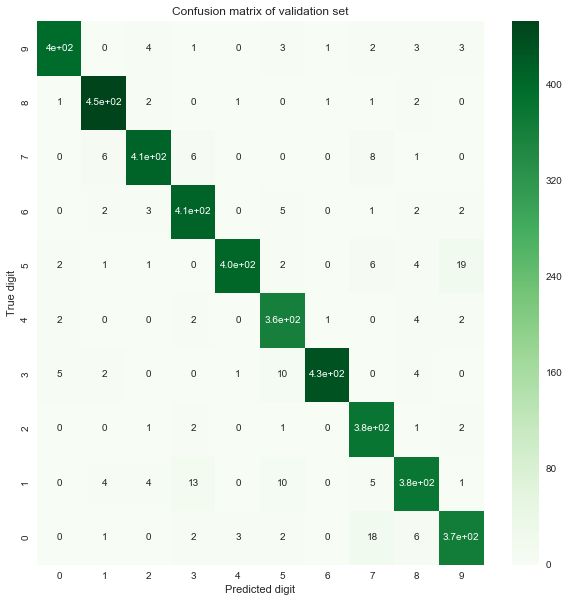

In [10]:
## show confusion matrix

mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
sess.close()

cnf_matrix = sklearn.metrics.confusion_matrix(
    one_hot_to_dense(y_valid_pred[mn]), one_hot_to_dense(y_valid)).astype(np.float32)

labels_array = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(1,figsize=(10,10))
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True digit')
plt.xlabel('Predicted digit')
plt.show();

/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification/working/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
final train/valid loss = 0.1556/0.1637, train/valid accuracy = 0.9498/0.9512


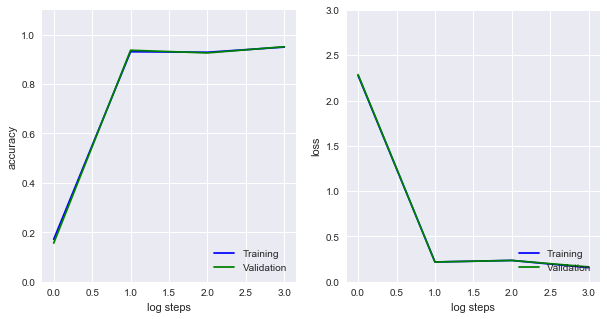

In [11]:
## loss and accuracy curves

mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
train_loss[mn], valid_loss[mn] = nn_graph.get_loss(sess)
train_acc[mn], valid_acc[mn] = nn_graph.get_accuracy(sess)
sess.close()

print('final train/valid loss = %.4f/%.4f, train/valid accuracy = %.4f/%.4f'%(
    train_loss[mn][-1], valid_loss[mn][-1], train_acc[mn][-1], valid_acc[mn][-1]))

plt.figure(figsize=(10, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(0,len(train_acc[mn])), train_acc[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_acc[mn])), valid_acc[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.0)
plt.ylabel('accuracy')
plt.xlabel('log steps');

plt.subplot(1,2,2)
plt.plot(np.arange(0,len(train_loss[mn])), train_loss[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss[mn])), valid_loss[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 3.0, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('log steps');

/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification/working/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
W_conv1: min = -0.228257 max = 0.270737 mean = 0.00794541 std = 0.105798
W_conv2: min = -0.252426 max = 0.24795 mean = -0.00513055 std = 0.0902637
W_conv3: min = -0.25036 max = 0.236296 mean = -0.00639424 std = 0.0921064


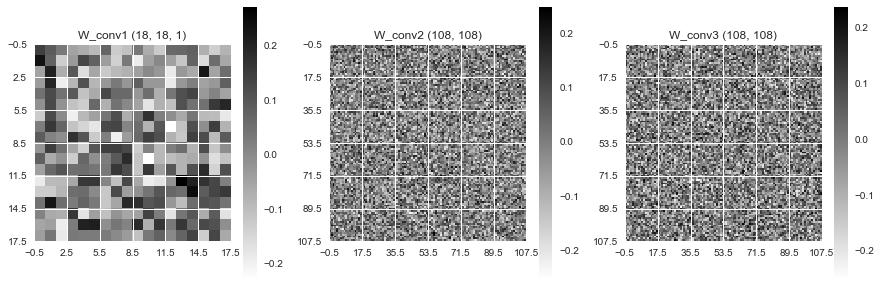

In [12]:
## visualize weights

mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
W_conv1, W_conv2, W_conv3, _, _ = nn_graph.get_weights(sess)
sess.close()

print('W_conv1: min = ' + str(np.min(W_conv1)) + ' max = ' + str(np.max(W_conv1))
      + ' mean = ' + str(np.mean(W_conv1)) + ' std = ' + str(np.std(W_conv1)))
print('W_conv2: min = ' + str(np.min(W_conv2)) + ' max = ' + str(np.max(W_conv2))
      + ' mean = ' + str(np.mean(W_conv2)) + ' std = ' + str(np.std(W_conv2)))
print('W_conv3: min = ' + str(np.min(W_conv3)) + ' max = ' + str(np.max(W_conv3))
      + ' mean = ' + str(np.mean(W_conv3)) + ' std = ' + str(np.std(W_conv3)))

s_f_conv1 = nn_graph.s_f_conv1
s_f_conv2 = nn_graph.s_f_conv2
s_f_conv3 = nn_graph.s_f_conv3

W_conv1 = np.reshape(W_conv1,(s_f_conv1,s_f_conv1,1,6,6))
W_conv1 = np.transpose(W_conv1,(3,0,4,1,2))
W_conv1 = np.reshape(W_conv1,(s_f_conv1*6,s_f_conv1*6,1))

W_conv2 = np.reshape(W_conv2,(s_f_conv2,s_f_conv2,6,6,36))
W_conv2 = np.transpose(W_conv2,(2,0,3,1,4))
W_conv2 = np.reshape(W_conv2,(6*s_f_conv2,6*s_f_conv2,6,6))
W_conv2 = np.transpose(W_conv2,(2,0,3,1))
W_conv2 = np.reshape(W_conv2,(6*6*s_f_conv2,6*6*s_f_conv2))

W_conv3 = np.reshape(W_conv3,(s_f_conv3,s_f_conv3,6,6,36))
W_conv3 = np.transpose(W_conv3,(2,0,3,1,4))
W_conv3 = np.reshape(W_conv3,(6*s_f_conv3,6*s_f_conv3,6,6))
W_conv3 = np.transpose(W_conv3,(2,0,3,1))
W_conv3 = np.reshape(W_conv3,(6*6*s_f_conv3,6*6*s_f_conv3))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.gca().set_xticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.gca().set_yticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv1 ' + str(W_conv1.shape))
plt.colorbar(plt.imshow(W_conv1[:,:,0], cmap=cm.binary));

plt.subplot(1,3,2)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv2 ' + str(W_conv2.shape))
plt.colorbar(plt.imshow(W_conv2[:,:], cmap=cm.binary));

plt.subplot(1,3,3)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv3 ' + str(W_conv3.shape))
plt.colorbar(plt.imshow(W_conv3[:,:], cmap=cm.binary));


/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification/working/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
h_fc2 =  [[ 0.72 -5.4  -1.56  0.1  -2.35 -0.29 -1.5  -3.17  6.99  0.17]]


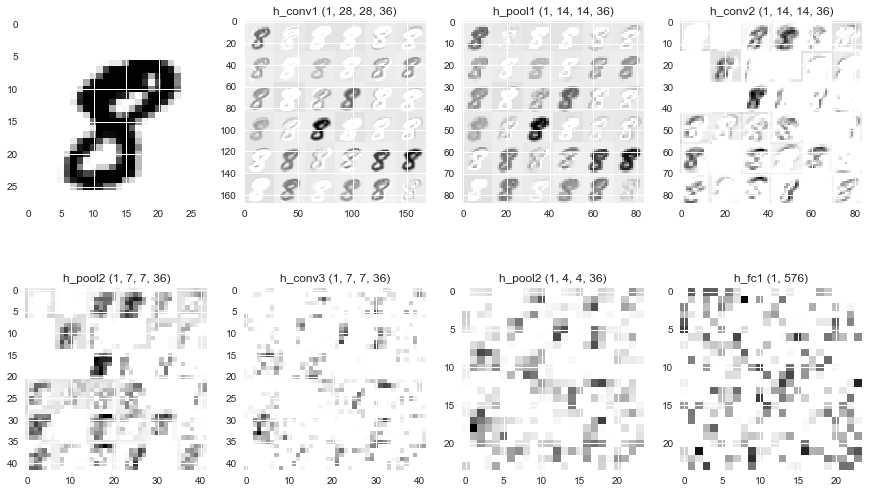

In [13]:
## visualize activations

img_no = 10;
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
(h_conv1, h_pool1, h_conv2, h_pool2,h_conv3, h_pool3, h_fc1,
 h_fc2) = nn_graph.get_activations(sess, x_train_valid[img_no:img_no+1])
sess.close()
    
# original image
plt.figure(figsize=(15,9))
plt.subplot(2,4,1)
plt.imshow(x_train_valid[img_no].reshape(28,28),cmap=cm.binary);

# 1. convolution
plt.subplot(2,4,2)
plt.title('h_conv1 ' + str(h_conv1.shape))
h_conv1 = np.reshape(h_conv1,(-1,28,28,6,6))
h_conv1 = np.transpose(h_conv1,(0,3,1,4,2))
h_conv1 = np.reshape(h_conv1,(-1,6*28,6*28))
plt.imshow(h_conv1[0], cmap=cm.binary);

# 1. max pooling
plt.subplot(2,4,3)
plt.title('h_pool1 ' + str(h_pool1.shape))
h_pool1 = np.reshape(h_pool1,(-1,14,14,6,6))
h_pool1 = np.transpose(h_pool1,(0,3,1,4,2))
h_pool1 = np.reshape(h_pool1,(-1,6*14,6*14))
plt.imshow(h_pool1[0], cmap=cm.binary);

# 2. convolution
plt.subplot(2,4,4)
plt.title('h_conv2 ' + str(h_conv2.shape))
h_conv2 = np.reshape(h_conv2,(-1,14,14,6,6))
h_conv2 = np.transpose(h_conv2,(0,3,1,4,2))
h_conv2 = np.reshape(h_conv2,(-1,6*14,6*14))
plt.imshow(h_conv2[0], cmap=cm.binary);

# 2. max pooling
plt.subplot(2,4,5)
plt.title('h_pool2 ' + str(h_pool2.shape))
h_pool2 = np.reshape(h_pool2,(-1,7,7,6,6))
h_pool2 = np.transpose(h_pool2,(0,3,1,4,2))
h_pool2 = np.reshape(h_pool2,(-1,6*7,6*7))
plt.imshow(h_pool2[0], cmap=cm.binary);

# 3. convolution
plt.subplot(2,4,6)
plt.title('h_conv3 ' + str(h_conv3.shape))
h_conv3 = np.reshape(h_conv3,(-1,7,7,6,6))
h_conv3 = np.transpose(h_conv3,(0,3,1,4,2))
h_conv3 = np.reshape(h_conv3,(-1,6*7,6*7))
plt.imshow(h_conv3[0], cmap=cm.binary);

# 3. max pooling
plt.subplot(2,4,7)
plt.title('h_pool2 ' + str(h_pool3.shape))
h_pool3 = np.reshape(h_pool3,(-1,4,4,6,6))
h_pool3 = np.transpose(h_pool3,(0,3,1,4,2))
h_pool3 = np.reshape(h_pool3,(-1,6*4,6*4))
plt.imshow(h_pool3[0], cmap=cm.binary);

# 4. FC layer
plt.subplot(2,4,8)
plt.title('h_fc1 ' + str(h_fc1.shape))
h_fc1 = np.reshape(h_fc1,(-1,24,24))
plt.imshow(h_fc1[0], cmap=cm.binary);

# 5. FC layer
np.set_printoptions(precision=2)
print('h_fc2 = ', h_fc2)

/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification/working/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
# false predictions:  205 out of 4200


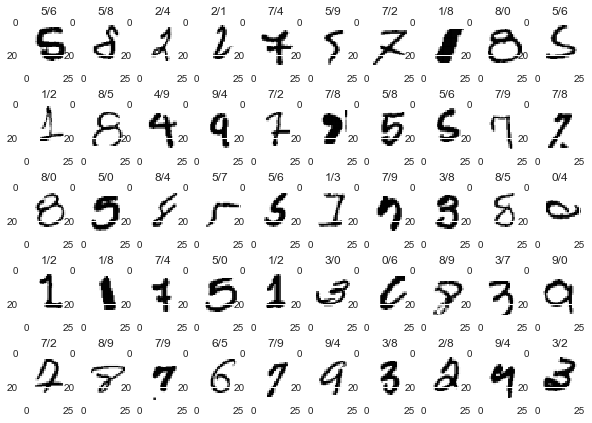

In [14]:
## show misclassified images

mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
sess.close()

y_valid_pred_label = one_hot_to_dense(y_valid_pred[mn])
y_valid_label = one_hot_to_dense(y_valid)
y_val_false_index = []

for i in range(y_valid_label.shape[0]):
    if y_valid_pred_label[i] != y_valid_label[i]:
        y_val_false_index.append(i)

print('# false predictions: ', len(y_val_false_index),'out of', len(y_valid))

plt.figure(figsize=(10,15))
for j in range(0,5):
    for i in range(0,10):
        if j*10+i<len(y_val_false_index):
            plt.subplot(10,10,j*10+i+1)
            plt.title('%d/%d'%(y_valid_label[y_val_false_index[j*10+i]],
                               y_valid_pred_label[y_val_false_index[j*10+i]]))
            plt.imshow(x_valid[y_val_false_index[j*10+i]].reshape(28,28),cmap=cm.binary)    

# 7. Stacking of models and training a meta-model  <a class="anchor" id="7-bullet"></a> 

In [15]:
## read test data

# read test data from CSV file 
if os.path.isfile('../input/test.csv'):
    test_df = pd.read_csv('../input/test.csv') # on kaggle 
    print('test.csv loaded: test_df{0}'.format(test_df.shape))
elif os.path.isfile('data/test.csv'):
    test_df = pd.read_csv('data/test.csv') # on local environment
    print('test.csv loaded: test_df{0}'.format(test_df.shape))
else:
    print('Error: test.csv not found')
    
# transforma and normalize test data
x_test = test_df.iloc[:,0:].values.reshape(-1,28,28,1) # (28000,28,28,1) array
x_test = x_test.astype(np.float)
x_test = normalize_data(x_test)
print('x_test.shape = ', x_test.shape)

# for saving results
y_test_pred = {}
y_test_pred_labels = {}

test.csv loaded: test_df(28000, 784)
x_test.shape =  (28000, 28, 28, 1)


In [16]:
## Stacking of neural networks

if False:
    
    take_models = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']

    # cross validations
    # choose the same seed as was done for training the neural nets
    kfold = sklearn.model_selection.KFold(len(take_models), shuffle=True, random_state = 123)

    # train and test data for meta model
    x_train_meta = np.array([]).reshape(-1,10)
    y_train_meta = np.array([]).reshape(-1,10)
    x_test_meta = np.zeros((x_test.shape[0], 10))

    print('Out-of-folds predictions:')

    # make out-of-folds predictions from base models
    for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

        # training and validation data
        x_train = x_train_valid[train_index]
        y_train = y_train_valid[train_index]
        x_valid = x_train_valid[valid_index]
        y_valid = y_train_valid[valid_index]

        # load neural network and make predictions
        mn = take_models[i] 
        nn_graph = nn_class()
        sess = nn_graph.load_session_from_file(mn)
        y_train_pred[mn] = nn_graph.forward(sess, x_train[:len(x_valid)])
        y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
        y_test_pred[mn] = nn_graph.forward(sess, x_test)
        sess.close()

        # create cloned model from base models
        #model = sklearn.base.clone(base_models[take_models[i]])
        #model.fit(x_train, y_train)
        #y_train_pred_proba['tmp'] = model.predict_proba(x_train)[:,1]
        #y_valid_pred_proba['tmp'] = model.predict_proba(x_valid)[:,1]
        #y_test_pred_proba['tmp'] = model.predict_proba(x_test)[:,1]

        # collect train and test data for meta model 
        x_train_meta = np.concatenate([x_train_meta, y_valid_pred[mn]])
        y_train_meta = np.concatenate([y_train_meta, y_valid]) 
        x_test_meta += y_test_pred[mn]

        print(take_models[i],': train/valid accuracy = %.4f/%.4f'%(
            accuracy_from_one_hot_labels(y_train_pred[mn], y_train[:len(x_valid)]),
            accuracy_from_one_hot_labels(y_valid_pred[mn], y_valid)))

        if False:
            break;

    # take average of test predictions
    x_test_meta = x_test_meta/(i+1)
    y_test_pred['stacked_models'] = x_test_meta

    print('')
    print('Stacked models: valid accuracy = %.4f'%accuracy_from_one_hot_labels(x_train_meta,
                                                                               y_train_meta))
     

In [17]:
## use meta model

if False:
    
    logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs',
                                                     multi_class='multinomial')
    
    # choose meta model
    take_meta_model = 'logreg'

    # train meta model
    model = sklearn.base.clone(base_models[take_meta_model]) 
    model.fit(x_train_meta, one_hot_to_dense(y_train_meta))
    
    y_train_pred['meta_model'] = model.predict_proba(x_train_meta)
    y_test_pred['meta_model'] = model.predict_proba(x_test_meta)

    print('Meta model: train accuracy = %.4f'%accuracy_from_one_hot_labels(x_train_meta, 
                                                           y_train_pred['meta_model']))

In [18]:
## choose one single model for test prediction

if True:
    
    mn = nn_name[0] # choose saved model
    nn_graph = nn_class() # create instance
    sess = nn_graph.load_session_from_file(mn) # receive session 
    y_test_pred = {}
    y_test_pred_labels = {}

    # split evaluation of test predictions into batches
    kfold = sklearn.model_selection.KFold(40, shuffle=False) 
    for i,(train_index, valid_index) in enumerate(kfold.split(x_test)):
        if i==0:
            y_test_pred[mn] = nn_graph.forward(sess, x_test[valid_index])
        else: 
            y_test_pred[mn] = np.concatenate([y_test_pred[mn],
                                              nn_graph.forward(sess, x_test[valid_index])])

    sess.close()
    
    

/Users/raoul/Documents/anaconda-workspace/Kaggle/MNIST_Classification/working/tmp.meta
INFO:tensorflow:Restoring parameters from tmp


# 8. Submit the test results <a class="anchor" id="8-bullet"></a> 

In [19]:
# choose the test predictions and submit the results

#mn = 'meta_model'
mn = nn_name[0]
y_test_pred_labels[mn] = one_hot_to_dense(y_test_pred[mn])

print(mn+': y_test_pred_labels[mn].shape = ', y_test_pred_labels[mn].shape)
unique, counts = np.unique(y_test_pred_labels[mn], return_counts=True)
print(dict(zip(unique, counts)))

# save predictions
np.savetxt('submission.csv', 
           np.c_[range(1,len(x_test)+1), y_test_pred_labels[mn]], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

print('submission.csv completed')

tmp: y_test_pred_labels[mn].shape =  (28000,)
{0: 2845, 1: 3177, 2: 2828, 3: 2730, 4: 2953, 5: 2402, 6: 2843, 7: 2719, 8: 2750, 9: 2753}
submission.csv completed


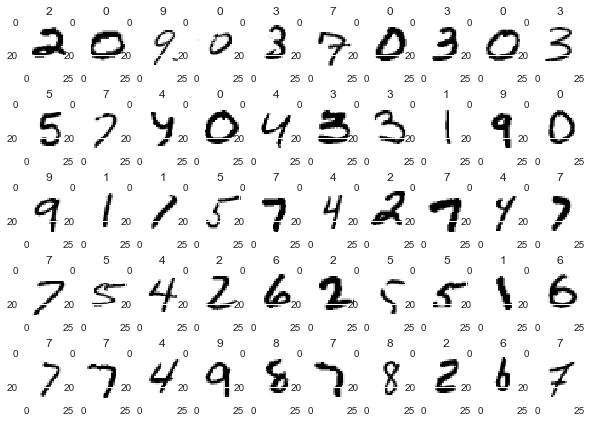

In [20]:
## look at some test images and predicted labels

plt.figure(figsize=(10,15))
for j in range(0,5):
    for i in range(0,10):
        plt.subplot(10,10,j*10+i+1)
        plt.title('%d'%y_test_pred_labels[mn][j*10+i])
        plt.imshow(x_test[j*10+i].reshape(28,28), cmap=cm.binary)
